<a href="https://colab.research.google.com/github/nicoelbert/deepflash2/blob/master/nbs/tutorial_train_and_pred_3channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/nicoelbert/deepflash2/blob/master/nbs/tutorial_train_and_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepflash2 - Train and Predict Tutorial
This notebook is optmizied to be executed on Google Colab (https://colab.research.google.com). It reproduces the results of the deepflash2 [paper](https://arxiv.org/abs/2111.06693) for semantic and instance segmentation.


*   Please read the instructions carefully.
*   Press the the *play* butten to execute the cells. It will show up between \[     \] on the left side of the code cells. 
*   Run the cells consecutively.

*References*:

Griebel, M., Segebarth, D., Stein, N., Schukraft, N., Tovote, P., Blum, R., & Flath, C. M. (2021). Deep-learning in the bioimaging wild: Handling ambiguous data with deepflash2. arXiv preprint arXiv:2111.06693.

>[deepflash2 - Train and Predict Tutorial](#scrollTo=RxDLprsbAwFB)

>>[Setup](#scrollTo=QdQqu0uiAwFB)

>>>[Settings](#scrollTo=5e3H5-UVAwFC)

>>>[Example Data](#scrollTo=D-tcpoRgAwFE)

>>>[Own Data](#scrollTo=feB973ZuAwFM)

>>>>[Google Drive & local](#scrollTo=Y5lfcip6AwFM)

>>>>[.zip file](#scrollTo=l1GU6IUHAwFM)

>>>[Data preprocessing](#scrollTo=VHmM_VSTAwFN)

>>[Train models](#scrollTo=8_GWdJM_AwFN)

>>[Prediction on test set](#scrollTo=kI3khgKLAwFN)



## Setup
In this section, you will set up the training environment, install all dependencies and connect to the drive with the prepared datasets.

In [1]:
!pip install deepflash2 --q

# Imports
import numpy as np
from deepflash2.all import *
from pathlib import Path


### Settings



Prior to Training the dataset needs to be selected. If you don't run the notebook in Colab, the `OUTPUT_PATH`and `MODEL_PATH` need to be adjusted to point on existing directorys.

In [2]:
# Connect to drive
try:
  from google.colab import drive
  drive.mount('/gdrive')
except:
  print('Google Drive is not available.')

SEED = 0 # We used seeds [0,1,2] in our experiemnts
OUTPUT_PATH = Path("/content/predictions") # Save predictions here
MODEL_PATH = Path("/content/models") # Save models here
TRAINED_MODEL_PATH= Path('/gdrive/MyDrive/deepflash2-paper/models/')

# deepflash2 config class
cfg = Config(random_state=SEED)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


For training, either the data from a prepared example dataset or own datasets can be used. These can come from a publicly available `.zip` file, or a specified directory in your Google Drive(for colab execution) or on your machine(for local execution).

In [3]:
DATASOURCE = 'ZIP File' #@param ["Example Data", "ZIP File", "Own Directory"]


### Example Data

Example data and trained models are available on [Google Drive](https://drive.google.com/drive/folders/1r9AqP9qW9JThbMIvT0jhoA5mPxWEeIjs?usp=sharing). To use the data in Google Colab, create a [**shortcut**](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive. This shortcut only has to be created once and doesn't affect your personal Google Drive storage.


Choose from the perpared dataset from `PV_in_HC`,  `cFOS_in_HC`, `mScarlet_in_PAG`,  `YFP_in_CTX`, `GFAP_in_HC`. Choose the one most similar to yours. A brief describtion of the datasets can be found below. 


In [4]:
if DATASOURCE == 'Example Data':
  DATASET = 'cFOS_in_HC' #@param ["PV_in_HC", "cFOS_in_HC", "mScarlet_in_PAG", "YFP_in_CTX", "GFAP_in_HC"]
  DATA_PATH = Path('/gdrive/MyDrive/deepflash2-paper/data')


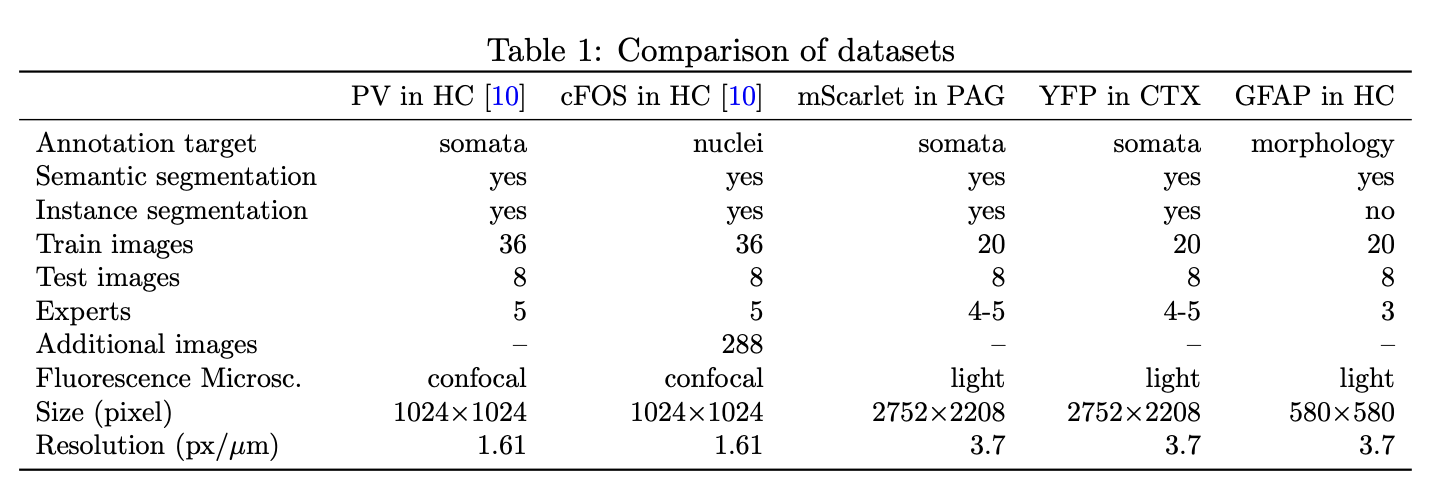

### Own Data

To use your own data sets, make sure that the folder structure is a described in the graphics below and adjust the `DATA_PATH` variable. You can either reference a folder from your personal google drive, give the url to a publicly available `.zip` file or reference a local folder if you run the notebook locally. The folder structure in the directory should be like the one shown below.


* /`YOUR_DATASET_NAME`
    *   /`train`
        * /`images`
        * /`masks_STAPLE`

    *   /`test`(only necessary when testing) 
        * /`images`
        * /`masks_STAPLE`




#### Google Drive & local
To use your own data from the Google Drive, or your machine if you run the notebook locally, change the `DATA_PATH` variable to the correct directory.
 


In [5]:
if DATASOURCE == 'Own Directory':
  #specify if the path of your directory
  DATA_PATH = Path('/path/to/your/directory')
  DATASET = 'your_dataset_name'



#### .zip file

To use the data from a publicly avaialbe zip file, specify the url alongside the name of the dataset folder in the zip file.

In [ ]:
if DATASOURCE == 'ZIP File':
  
  #specify url of the .zip file and dataset name
  DATASET = 'your_dataset_name'
  file_name = 'your_zipfile_name.zip'


  from google.colab import files
  from zipfile import ZipFile
  import os
  from pathlib import Path

  # define extraction directory and check for existence
  
  DATA_PATH = Path('/content/data')
  if not os.path.isdir(DATA_PATH):
      os.makedirs('/content/data')

  upload = files.upload()

  zip = ZipFile('/content/'+file_name)
  zip.extractall(path=DATA_PATH)
  

### Data preprocessing

- Initialize `EnsembleLearner`
- Plot images and masks to show if they are correctly loaded

Found 36 images in "images" and 36 masks in "masks_STAPLE".
Computing Stats...


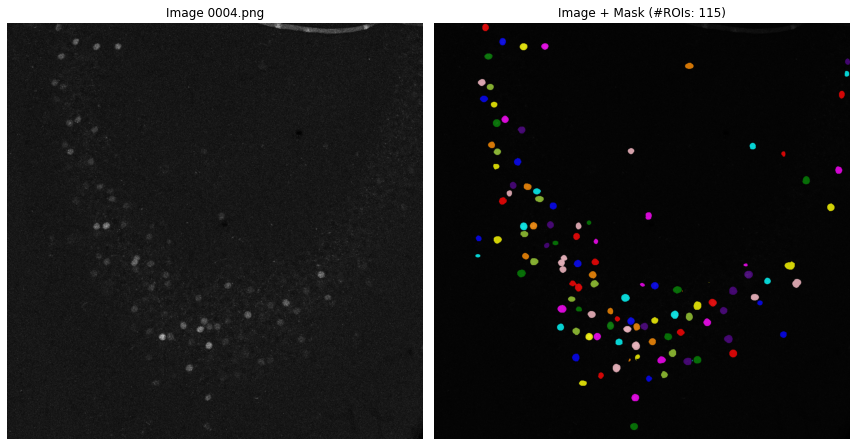

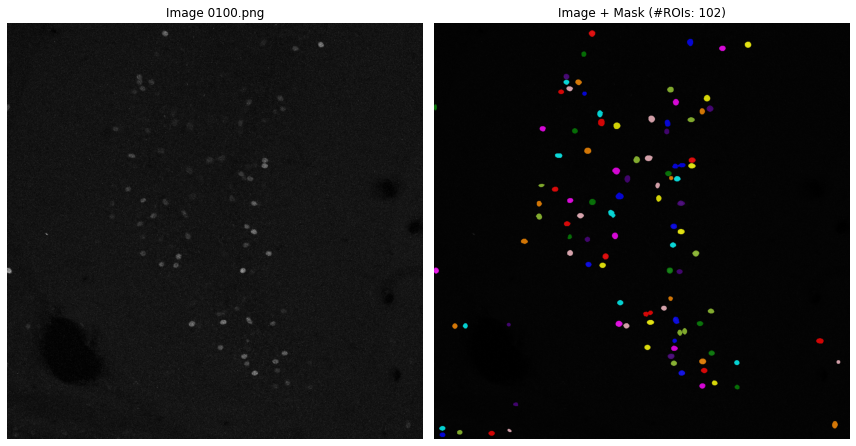

In [9]:
train_data_path = DATA_PATH/DATASET/'train'
ensemble_path = MODEL_PATH/DATASET

el = EnsembleLearner(image_dir='images', 
                     mask_dir='masks_STAPLE', 
                     config=cfg, 
                     path=train_data_path, 
                     ensemble_path=ensemble_path)

el.ds.show_data(max_n=2, overlay=True)

## Train models

- Train model ensemble with 5 models
  - 2500 iterations for each model
- You can skip this step use the trained models from our paper (see next section).

In [ ]:
n_iter = 2500
el.fit_ensemble(n_iter)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Using preprocessed masks from <zarr.storage.TempStore object at 0x7f55369da790>
Using preprocessed masks from <zarr.storage.TempStore object at 0x7f55369da790>


Starting training for Unet_resnet34_2classes-fold1.pth


epoch,train_loss,valid_loss,dice,time


epoch,train_loss,valid_loss,dice,time


## Prediction on test set

We save
- Semantic segmentation masks (.png)
- Instance segmentation masks (.tif) using the cellpose flow representations
- Foreground uncertainty scores *U*

To ensure reproducibilty we will use the trained models from our paper!

In [ ]:
test_data_path = DATA_PATH/DATASET/'test'
ensemble_trained_path = TRAINED_MODEL_PATH/DATASET/f'{SEED+1}'
prediction_path = OUTPUT_PATH/DATASET

el_pred = EnsembleLearner('images',
                          path=test_data_path, 
                          config=cfg, 
                          ensemble_path=ensemble_trained_path) 

# Predict and save semantic segmentation masks
el_pred.get_ensemble_results(el_pred.files, 
                             use_tta=True, 
                             export_dir=prediction_path/'masks')
# Save uncertainty scores
df_unc = el_pred.df_ens[['file', 'ensemble', 'n_models', 'uncertainty_score']]
df_unc.to_csv(prediction_path/'uncertainty_scores.csv', index=False)

# Show results scores
el_pred.show_ensemble_results()

In [ ]:
# Predict and save instance segmentation masks
el_pred.get_cellpose_results(export_dir=prediction_path/'instance_masks')
el_pred.show_cellpose_results()